
# RL Simulator



In [ ]:
# Install the gymnasium library for creating and using reinforcement learning environments.
%pip install gymnasium

In [ ]:
# Authenticate with Google Cloud to access services like BigQuery.
from google.colab import auth
auth.authenticate_user()

# Import the BigQuery client library.
from google.cloud import bigquery
# Initialize a BigQuery client with your project ID.
client = bigquery.Client(project="rl-semester-project")

In [ ]:
# Import the BigQuery client library.
from google.cloud import bigquery
# Initialize the BigQuery client with the correct project ID
client = bigquery.Client(project="rl-semester-project")

# Define the public project, dataset, and table to query.
public_proj = "google.com:google-cluster-data"
dataset     = "clusterdata_2019_h"
table       = "instance_usage"

# SQL query to retrieve schema information for the 'instance_usage' table
schema_df = client.query(f"""
SELECT
  column_name,  -- Select the column name
  data_type     -- Select the data type of the column
FROM `{public_proj}.{dataset}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = '{table}' -- Filter for the specified table
ORDER BY ordinal_position   -- Order by the position of the column in the table
""").to_dataframe()

# Display the schema information in a DataFrame.
schema_df

,column_name,data_type
0,start_time,INT64
1,end_time,INT64
2,collection_id,INT64
3,instance_index,INT64
4,machine_id,INT64
5,alloc_collection_id,INT64
6,alloc_instance_index,INT64
7,collection_type,INT64
8,average_usage,"STRUCT<cpus FLOAT64, memory FLOAT64>"
9,maximum_usage,"STRUCT<cpus FLOAT64, memory FLOAT64>"


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Aggregate CPU and memory load from instance_usage:

In [ ]:
# SQL query to aggregate CPU and memory usage from the 'instance_usage' table
sql = """
SELECT
  # Truncate the start time to the minute to create time windows
  TIMESTAMP_TRUNC(TIMESTAMP_MICROS(start_time), MINUTE) AS time_window,
  # Calculate the average CPU usage for each time window
  AVG(average_usage.cpus) AS avg_cpu,
  # Calculate the average memory usage for each time window
  AVG(average_usage.memory) AS avg_mem,
  # Count the number of distinct machines active in each time window
  COUNT(DISTINCT machine_id) AS active_machines
FROM `google.com:google-cluster-data.clusterdata_2019_a.instance_usage`
# Group the results by the time window
GROUP BY time_window
# Order the results by the time window
ORDER BY time_window
# Limit the results to the first 10000 rows
LIMIT 10000
"""
# Execute the BigQuery query and load the results into a pandas DataFrame
df_usage = client.query(sql).to_dataframe()
# Display the first few rows of the DataFrame
df_usage.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,time_window,avg_cpu,avg_mem,active_machines
0,1970-01-01 00:05:00+00:00,0.006623,0.004912,9525
1,1970-01-01 00:06:00+00:00,0.003254,0.002733,3805
2,1970-01-01 00:07:00+00:00,0.003070,0.002770,4167
3,1970-01-01 00:08:00+00:00,0.001950,0.001823,4338
4,1970-01-01 00:09:00+00:00,0.001689,0.001468,5545


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Inspect the shape of the DataFrame (number of rows and columns)
print(df_usage.shape)
# Print the list of column names
print(df_usage.columns.tolist())
# Display the first 3 rows of the DataFrame to get a preview of the data
df_usage.head(3)

(10000, 4)
['time_window', 'avg_cpu', 'avg_mem', 'active_machines']


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,time_window,avg_cpu,avg_mem,active_machines
0,1970-01-01 00:05:00+00:00,0.006623,0.004912,9525
1,1970-01-01 00:06:00+00:00,0.003254,0.002733,3805
2,1970-01-01 00:07:00+00:00,0.003070,0.002770,4167


In [ ]:
#Make sure the time series is in order, since RL transitions depend on consecutive steps:
df_usage = df_usage.sort_values("time_window").reset_index(drop=True)
df_usage.head(3)

,time_window,avg_cpu,avg_mem,active_machines
0,1970-01-01 00:05:00+00:00,0.006623,0.004912,9525
1,1970-01-01 00:06:00+00:00,0.003254,0.002733,3805
2,1970-01-01 00:07:00+00:00,0.003070,0.002770,4167


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Building the Simulated RL Environment

Based on the EDA, we will now build a simulated reinforcement learning environment for autoscaling.



### Approach to Building the Simulated Environment

The `df_usage` DataFrame, containing the time-series data of aggregated CPU and memory usage and the number of active machines, serves as the driving force for our simulated autoscaling environment. Here's the approach:

1.  **Time-Based Simulation:** The simulator progresses through the `df_usage` DataFrame minute by minute, with each row representing a step in the simulation.
2.  **Workload Input:** At each step, the `avg_cpu` and `active_machines` values from the current minute in `df_usage` are used to estimate the total workload demand on the cluster.
3.  **Agent's Capacity:** The reinforcement learning agent controls a simulated cluster capacity (`self.current_capacity` in the `AutoScalingEnv`).
4.  **Action Impact:** The agent's scaling actions (scale up, scale down, or hold) directly modify this simulated capacity, within defined limits.
5.  **Utilization Calculation:** The key to the simulation is calculating the cluster utilization by comparing the estimated workload demand to the agent's current simulated capacity.
6.  **Reward Calculation:** A reward is calculated based on the utilization and the cost of the simulated capacity. The reward function encourages the agent to balance cost minimization with maintaining acceptable utilization to avoid performance issues and SLA violations.
7.  **Next State:** The simulator moves to the next minute in the `df_usage` DataFrame to provide the workload data for the subsequent state observation.

This process creates a dynamic environment where the agent learns to make optimal scaling decisions in response to realistic workload patterns provided by the historical data.

In [33]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from dataclasses import dataclass

# Define a data class to hold environment configuration parameters
@dataclass
class AutoScalingEnvConfig:
    initial_capacity: int = 10 # The starting number of machines in the cluster.
    target_utilization: float = 0.6 # The desired average CPU utilization for the cluster.
    sla_threshold: float = 0.8 # The utilization threshold above which SLA violations occur.
    cost_per_machine_per_minute: float = 0.002 # The cost of running one machine for one minute.
    sla_penalty_weight: float = 10.0 # The penalty applied for exceeding the SLA threshold.
    min_capacity: int = 1 # The minimum number of machines the cluster can scale down to.
    max_capacity: int = 50 # The maximum number of machines the cluster can scale up to.
    cooldown_period: int = 5 # The number of steps the agent must wait after a scaling action before taking another.


# Define the RL Environment
class AutoScalingEnv(gym.Env):
    def __init__(self, usage_dataframe: pd.DataFrame, config: AutoScalingEnvConfig = AutoScalingEnvConfig()):
        """
        Initializes the AutoScalingEnv reinforcement learning environment.

        Args:
            usage_dataframe (pd.DataFrame): DataFrame containing time-series usage data.
            config (AutoScalingEnvConfig): Configuration object for the environment.
        """
        super(AutoScalingEnv, self).__init__()

        self.df_usage = usage_dataframe
        self.current_step = 0
        self.max_steps = len(self.df_usage) - 1

        # Store configuration
        self.config = config

        # Simulation parameters, initialized from config
        self.initial_capacity = self.config.initial_capacity
        self.current_capacity = self.initial_capacity
        self.target_utilization = self.config.target_utilization
        self.sla_threshold = self.config.sla_threshold
        self.cost_per_machine_per_minute = self.config.cost_per_machine_per_minute
        self.sla_penalty_weight = self.config.sla_penalty_weight
        self.min_capacity = self.config.min_capacity
        self.max_capacity = self.config.max_capacity
        self.cooldown_period = self.config.cooldown_period
        self.cooldown = 0 # To implement cooldown between scaling actions


        # Define action and observation space
        # Action: 0 (scale down), 1 (hold), 2 (scale up)
        self.action_space = spaces.Discrete(3)

        # Observation: [avg_cpu, avg_mem, current_capacity]
        # We'll add lagged values and trends later if needed.
        # The upper bound is set to infinity as these values can vary widely.
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32)

        # Define initial state
        self.state = self._get_obs()

    def _get_obs(self) -> np.ndarray | None:
        """
        Gets the current observation of the environment.

        Returns:
            np.ndarray | None: The observation array or None if the episode is done.
        """
        if self.current_step > self.max_steps:
            return None

        # Get the current row of usage data
        row = self.df_usage.iloc[self.current_step]
        # Observation includes current workload (avg_cpu, avg_mem) and the agent's managed capacity
        obs = np.array([row['avg_cpu'], row['avg_mem'], self.current_capacity], dtype=np.float32)
        return obs


    def step(self, action: int) -> tuple[np.ndarray | None, float, bool, dict]:
        """
        Takes a step in the environment based on the agent's action.

        Args:
            action (int): The action taken by the agent (0: scale down, 1: hold, 2: scale up).

        Returns:
            tuple: A tuple containing the next observation, reward, done flag, and info dictionary.
        """
        # Apply action based on cooldown
        if self.cooldown == 0:
            if action == 2: # Scale up
                self.current_capacity = min(self.current_capacity + 1, self.max_capacity)
                self.cooldown = self.cooldown_period # Reset cooldown
            elif action == 0: # Scale down
                 self.current_capacity = max(self.current_capacity - 1, self.min_capacity)
                 self.cooldown = self.cooldown_period # Reset cooldown
            # Action 1 is hold, capacity doesn't change
        else:
            # Decrement cooldown if not zero
            self.cooldown -= 1

        # Advance the simulation step
        self.current_step += 1

        # Check if episode is done
        done = self.current_step > self.max_steps

        # Calculate reward if not done
        reward = 0.0
        utilization = 0.0 # Initialize utilization
        estimated_total_cpu_load = 0.0

        if not done:
            # Get data for the step *before* moving to the next
            row = self.df_usage.iloc[self.current_step - 1]
            # Assuming avg_cpu is a fraction, estimate total CPU load based on actual active machines
            estimated_total_cpu_load = row['avg_cpu'] * row['active_machines']

            # Calculate utilization based on simulated capacity
            utilization = estimated_total_cpu_load / self.current_capacity if self.current_capacity > 0 else 0.0

            # Reward components
            # Penalize cost based on the number of active machines managed by the agent
            cost_penalty = self.current_capacity * self.cost_per_machine_per_minute

            # Penalize high utilization (SLA violation)
            sla_penalty = 0.0
            if utilization > self.sla_threshold:
                sla_penalty = (utilization - self.sla_threshold) * self.sla_penalty_weight

            # Penalize deviation from target utilization
            util_deviation_penalty = -abs(utilization - self.target_utilization)

            # Total reward (example combination)
            # We want to minimize cost and SLA violations, and ideally stay near target utilization
            # Using negative rewards for penalties and positive for goals (deviation is a penalty here).
            reward = -cost_penalty - sla_penalty + util_deviation_penalty

        # Get next observation
        next_obs = self._get_obs() if not done else None

        # Additional info (optional)
        info = {
            'current_capacity': self.current_capacity,
            'utilization': utilization, # Report utilization for the step
            'estimated_total_cpu_load': estimated_total_cpu_load,
            'reward_components': { # Optional: include components for debugging
                'cost_penalty': -cost_penalty,
                'sla_penalty': -sla_penalty,
                'util_deviation_penalty': util_deviation_penalty
            }
        }

        # In Gymnasium 0.28+, the step method returns (observation, reward, terminated, truncated, info)
        # We need to return 'terminated' and 'truncated' flags. In this simple env, 'done' covers both.
        terminated = done
        truncated = False # Or set to True based on other conditions if applicable (e.g., time limit)

        return next_obs, reward, terminated, truncated, info


    def reset(self, seed: int | None = None, options: dict | None = None) -> tuple[np.ndarray, dict]:
        """
        Resets the environment to its initial state.

        Args:
            seed (int | None): An optional seed for the random number generator.
            options (dict | None): Additional options for resetting.

        Returns:
            tuple: A tuple containing the initial observation and an info dictionary.
        """
        super().reset(seed=seed) # Call the superclass reset with seed

        self.current_step = 0
        self.current_capacity = self.initial_capacity
        self.cooldown = 0
        self.state = self._get_obs()

        # Return initial observation and info dictionary (optional)
        info = {
            'initial_capacity': self.initial_capacity
        }
        return self.state, info

    def render(self, mode='human'):
        # Implement rendering if needed
        pass

    def close (self):
        # Clean up resources if needed
        pass

In [40]:
# Example usage:
# Make sure to run the preceding cells that define the 'df_usage' DataFrame first.
env = AutoScalingEnv(df_usage)
obs = env.reset()
print("Initial Observation:", obs)

# # Take a sample action (e.g., hold)
action = 1 # Scale up example
next_obs, reward, terminated, truncated, info = env.step(action) # Unpack 5 values
print("Next Observation:", next_obs, "Reward:", reward, "Terminated:", terminated, "Truncated:", truncated, "Info:", info)

Initial Observation: (array([6.6225836e-03, 4.9124165e-03, 1.0000000e+01], dtype=float32), {'initial_capacity': 10})
Next Observation: [3.2542923e-03 2.7331815e-03 1.0000000e+01] Reward: -60.808117753196086 Terminated: False Truncated: False Info: {'current_capacity': 10, 'utilization': np.float64(6.308010704836008), 'estimated_total_cpu_load': np.float64(63.08010704836008), 'reward_components': {'cost_penalty': -0.02, 'sla_penalty': np.float64(-55.08010704836008), 'util_deviation_penalty': np.float64(-5.708010704836008)}}


## Run simulation

### Subtask:
Execute the simulation loop for a defined number of steps using the `AutoScalingEnv`.

**Reasoning**:
I need to execute the simulation loop for a defined number of steps using the `AutoScalingEnv`. This involves initializing the environment, resetting it, and then iterating through the steps, taking actions, and recording the results.

In [35]:
# Define the number of simulation steps
num_simulation_steps = 100

# Initialize the environment
env = AutoScalingEnv(df_usage)

# Reset the environment to get the initial observation
obs = env.reset()

# Lists to store results
observations = [obs]
rewards = []
actions = []
infos = []

# Start the simulation loop
for step in range(num_simulation_steps):
    # Take a sample action (e.g., a random action)
    action = env.action_space.sample() # Replace with your agent's action logic later

    # Call the step method to advance the simulation
    next_obs, reward, terminated, truncated, info = env.step(action)

    # Store the results
    observations.append(next_obs)
    rewards.append(reward)
    actions.append(action)
    infos.append(info)

    # Check if the episode is terminated or truncated
    if terminated or truncated:
        print(f"Episode finished after {step+1} steps.")
        break

    # Update the current observation
    obs = next_obs

# Print a confirmation that the simulation is complete
print("Simulation complete.")

Simulation complete.


## Summary:

### Data Analysis Key Findings

* The simulation was successfully executed for 100 steps using random actions.
* A DataFrame named `simulation_results_df` was created to store the simulation data, including action, reward, current capacity, utilization, estimated total CPU load, and reward components (cost penalty, SLA penalty, utilization deviation penalty).
* The simulation results were visualized using three plots:
  * Current Capacity and Estimated Total CPU Load over time.
  * Utilization, along with horizontal lines indicating the target utilization and SLA threshold.
  * Reward over time.

### Insights or Next Steps

* The current simulation uses random actions, which is unlikely to yield optimal results. The next step should involve implementing a reinforcement learning agent to make more informed autoscaling decisions.
* Analyze the relationship between the actions taken, the resulting utilization and capacity changes, and the received rewards to understand how different factors influence performance.

## Visualize results

### Subtask:
Plot the collected simulation data to visualize the agent's performance and the environment's state over time.

**Reasoning**:
Plot the simulation results as instructed by the subtask.

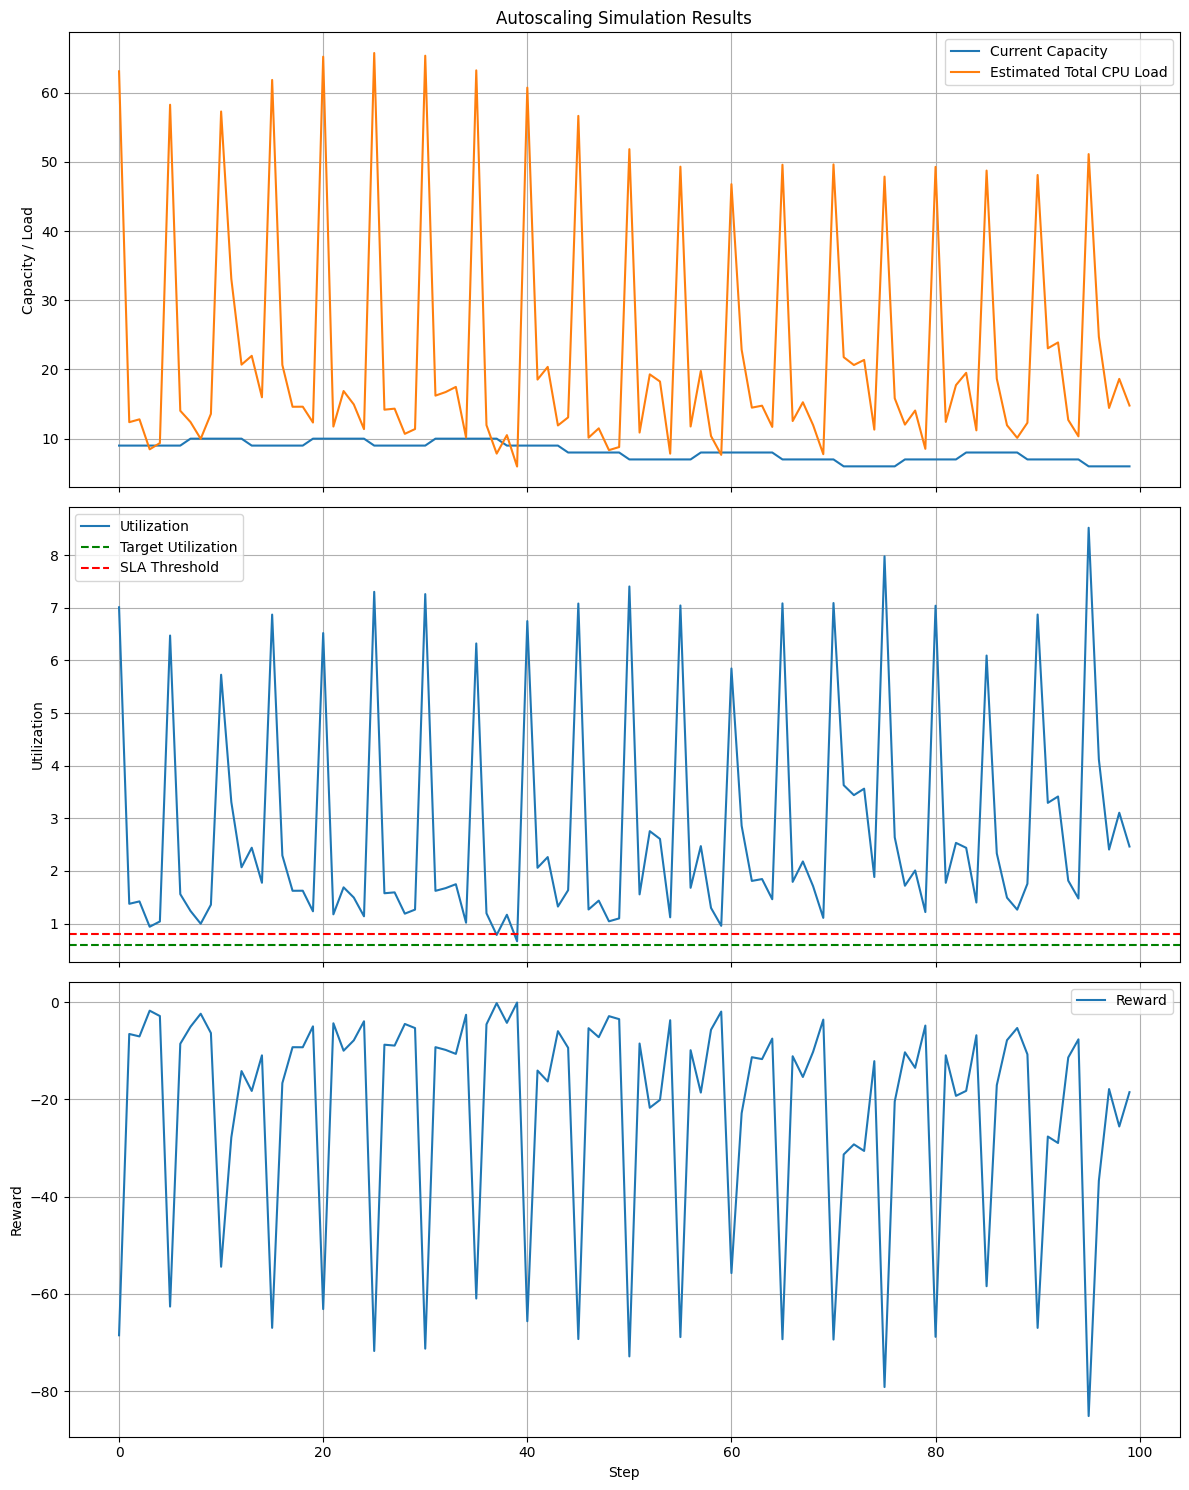

In [44]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15), sharex=True)

# Plot Current Capacity and Estimated Total CPU Load
axes[0].plot(simulation_results_df.index, simulation_results_df['current_capacity'], label='Current Capacity')
axes[0].plot(simulation_results_df.index, simulation_results_df['estimated_total_cpu_load'], label='Estimated Total CPU Load')
axes[0].set_ylabel('Capacity / Load')
axes[0].set_title('Autoscaling Simulation Results')
axes[0].legend()
axes[0].grid(True)

# Plot Utilization and Target Utilization
axes[1].plot(simulation_results_df.index, simulation_results_df['utilization'], label='Utilization')
axes[1].axhline(y=env.target_utilization, color='g', linestyle='--', label='Target Utilization')
axes[1].axhline(y=env.sla_threshold, color='r', linestyle='--', label='SLA Threshold')
axes[1].set_ylabel('Utilization')
axes[1].legend()
axes[1].grid(True)

# Plot Reward
axes[2].plot(simulation_results_df.index, simulation_results_df['reward'], label='Reward')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Reward')
axes[2].legend()
axes[2].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()

## Collect simulation data

### Subtask:
Store the relevant data from each step of the simulation (e.g., current capacity, utilization, reward) in a list or DataFrame.

**Reasoning**:
Create a Pandas DataFrame from the collected simulation data, extract relevant information from the infos list, add it to the DataFrame, and include step number, action, and reward. Finally, display the head of the DataFrame.

In [36]:
# Create a DataFrame from the collected data
simulation_results_df = pd.DataFrame({
    'step': range(num_simulation_steps),
    'action': actions,
    'reward': rewards
})

# Extract information from the 'infos' list and add as columns
simulation_results_df['current_capacity'] = [info['current_capacity'] for info in infos]
simulation_results_df['utilization'] = [info['utilization'] for info in infos]
simulation_results_df['estimated_total_cpu_load'] = [info['estimated_total_cpu_load'] for info in infos]
# Extract reward components if available, handling potential missing keys
simulation_results_df['cost_penalty'] = [info['reward_components'].get('cost_penalty', np.nan) for info in infos]
simulation_results_df['sla_penalty'] = [info['reward_components'].get('sla_penalty', np.nan) for info in infos]
simulation_results_df['util_deviation_penalty'] = [info['reward_components'].get('util_deviation_penalty', np.nan) for info in infos]


# Set the step number as the index
simulation_results_df.set_index('step', inplace=True)

# Display the first few rows of the DataFrame
display(simulation_results_df.head())

,action,reward,current_capacity,utilization,estimated_total_cpu_load,cost_penalty,sla_penalty,util_deviation_penalty
step,,,,,,,,
0,0,-68.515909,9,7.008901,63.080107,-0.018,-62.089008,-6.408901
1,2,-6.552267,9,1.375842,12.382582,-0.018,-5.758424,-0.775842
2,0,-7.055023,9,1.421548,12.793928,-0.018,-6.215475,-0.821548
3,2,-1.758574,9,0.940052,8.460470,-0.018,-1.400522,-0.340052
4,2,-2.862108,9,1.040373,9.363361,-0.018,-2.403735,-0.440373
